<a href="https://colab.research.google.com/github/SathyaSudha-96/Face_Mask_Detector_sathya/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
from PIL import Image
import os, os.path
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [28]:
 DIRECTORY = "/content/drive/MyDrive/Face-Mask-Detection/dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [33]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [35]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [40]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [42]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

In [44]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [64]:
 #load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


In [50]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [60]:
optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [65]:
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [66]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 136s 1s/step - loss: 0.3972 - accuracy: 0.8596 - val_loss: 0.1566 - val_accuracy: 0.9726
Epoch 2/20
95/95 [==============================] - 131s 1s/step - loss: 0.1462 - accuracy: 0.9661 - val_loss: 0.0831 - val_accuracy: 0.9804
Epoch 3/20
95/95 [==============================] - 132s 1s/step - loss: 0.1012 - accuracy: 0.9743 - val_loss: 0.0658 - val_accuracy: 0.9791
Epoch 4/20
95/95 [==============================] - 133s 1s/step - loss: 0.0791 - accuracy: 0.9763 - val_loss: 0.0564 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 132s 1s/step - loss: 0.0704 - accuracy: 0.9792 - val_loss: 0.0494 - val_accuracy: 0.9857
Epoch 6/20
95/95 [==============================] - 133s 1s/step - loss: 0.0621 - accuracy: 0.9835 - val_loss: 0.0427 - val_accuracy: 0.9844
Epoch 7/20
95/95 [==============================] - 132s 1s/step - loss: 0.0542 - accuracy: 0.9819 - val_loss: 0.0395 - val_accuracy: 0.9857
Epoch 8/20
95

In [67]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [68]:
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [71]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [72]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("/content/drive/MyDrive/Face-Mask-Detection/mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


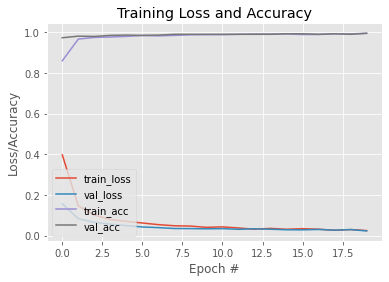

In [73]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")